# Workshop 5 Decision trees & random forests

Interesting sources: 
- https://learn.datacamp.com/courses/machine-learning-with-tree-based-models-in-python
- https://www.datacamp.com/community/tutorials/decision-tree-classification-python
- https://www.datacamp.com/community/tutorials/random-forests-classifier-python

![](https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/media/overview/tdsp-lifecycle2.png "Data Science Lifecycle")

In [6]:
import pandas as pd
df = pd.read_csv('data/EnergyCorp.csv', sep=';')
df.head()

,klantnr,huidig_contractduur,VERBRUIKGAS,VERBRUIKEL,VERBRUIKHOOG,VERBRUIKLAAG,nieuwsbrief,wervingskanaal,vast_variabel,grijs_groen,startlevering,eindlevering,contract_verlengd,welstand,levensfase,bouwjaar,soort_woning,inkomen,opleiding
0,10135,12,0,3047,0,0,Y,Online,vaste prijs,grijze stroom,11-10-2002,3-11-2004,niet verlengd,Laag,Alleenstaand,1940 tot 1969,Hoge flat,tussen modaal en 2 keer modaal keer modaal of ...,Midden
1,10150,12,0,0,3247,3257,Y,Online,vaste prijs,grijze stroom,11-10-2002,11-10-2005,niet verlengd,Hoog,Paar met kinderen,1970 tot 1989,Rijtjeshuis,modaal,Hoog
2,10159,12,0,2426,0,0,N,Online,vaste prijs,grijze stroom,11-10-2002,5-1-2007,niet verlengd,Midden,Paar met kinderen,Voor 1899,Rijtjeshuis,tussen modaal en 2 keer modaal,Hoog
3,10193,36,1616,2092,0,0,Y,Inbound,variabele prijs,groene stroom,17-10-2002,26-3-2012,niet verlengd,Laag,Paar met kinderen,Voor 1899,Lage flat,modaal,Laag
4,10206,12,0,2787,0,0,Y,Online,vaste prijs,groene stroom,11-10-2002,5-2-2009,niet verlengd,Hoog,Paar met kinderen,Voor 1899,Rijtjeshuis,modaal,Midden


In [7]:
df['contract_verlengd'].unique()

array(['niet verlengd', 'verlengd'], dtype=object)

In [8]:
df['contract_verlengd'].isna().sum()

0

In [9]:
def convert_contract_verlengd(contractVerlengd):
    if(contractVerlengd == 'verlengd'):
        return 0
    else:
        return 1

In [10]:
print(convert_contract_verlengd('verlengd'))
print(convert_contract_verlengd('niet verlengd'))

0
1


In [11]:
df['churned'] = df['contract_verlengd'].apply(convert_contract_verlengd)

In [12]:
df['churned'].head()

0    1
1    1
2    1
3    1
4    1
Name: churned, dtype: int64

In [13]:
df['churned'].mean()

0.4110071435758125

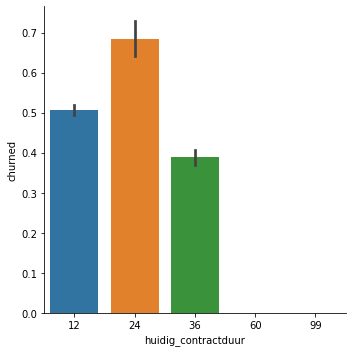

In [14]:
import seaborn as sns
sns.catplot(y="churned", x="huidig_contractduur", kind="bar", data=df);

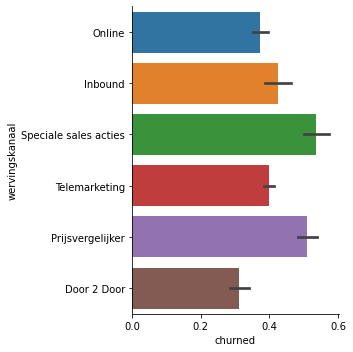

In [15]:
import seaborn as sns
sns.catplot(x="churned", y="wervingskanaal", kind="bar", data=df)

Most machine learning algorithms in Python can not handle categorical data directly. We will need to convert categorical data into numeric values. We can do so by creating **dummy variables**.

In [16]:
wervingskanaal_dummies = pd.get_dummies(df['wervingskanaal'])
wervingskanaal_dummies.head()

,Door 2 Door,Inbound,Online,Prijsvergelijker,Speciale sales acties,Telemarketing
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,1,0,0,0,0
4,0,0,1,0,0,0


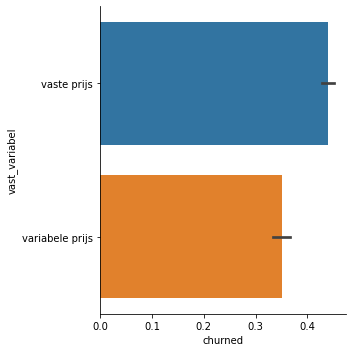

In [17]:
import seaborn as sns
sns.catplot(x="churned", y="vast_variabel", kind="bar", data=df)

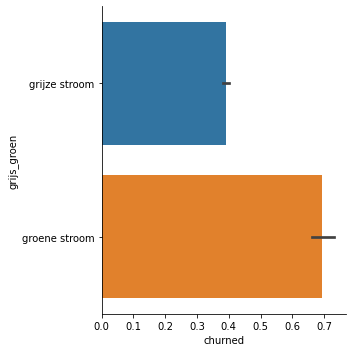

In [18]:
import seaborn as sns
sns.catplot(x="churned", y="grijs_groen", kind="bar", data=df)

In [19]:
df_prepped = df.join(wervingskanaal_dummies)
df_prepped['vaste_prijs'] = df['vast_variabel'] == 'vaste prijs'
df_prepped['groene_stroom'] = df['grijs_groen'] == 'groene stroom'

## Training and Testing

We not only have to train our decision tree model, we should also verify that it works. However, we just have one dataset available to us...

With this verification we make sure that we don't **overfit** the model. We could learn to output exactly the right answer of our data set, but we might not get any new data correct. We'll dive into this deeper later in the notebook. The [wikipedia](https://en.wikipedia.org/wiki/Overfitting) page on overfitting is also a good resource to learn more on overfitting.

A standard solution to this problem is dividing up the data you have available into a **training set** and a **test set**. We train the model on the training set and verify that we didn't overfit on the test set. 

Let's split our data set!

In [20]:
from sklearn.model_selection import train_test_split
train_test_split?

In [21]:
df_train, df_test = train_test_split(df_prepped, test_size=0.3, stratify=df['churned'], random_state=42)
print(df_train.shape, df_test.shape)

(6957, 28) (2982, 28)


In [22]:
print(df_train['churned'].mean())
print(df_test['churned'].mean())

0.41095299698145754
0.41113346747149565


## Evaluation
One very important step in your data science flow is to choose an appropriate evaluation metric for your problem.

Regression
- RMSE
- ...

Classification
- True positive rate & False positive rate
- Area under the ROC curve (AUROC)
-  ...

**Avoid ussing accuracy as your evaluation metric**. Accuracy does not distinguish between type 1 and type 2 error.
![](https://mk0abtastybwtpirqi5t.kinstacdn.com/wp-content/uploads/type-1-2-errors.png)
This results in the following two important downsides:
- Accuracy alone doesn't provide you with any insight about whether your model has learned anything and whether it is useful. For example let's say that we want to predict whether a person has COVID and let's say that 0.1% of the population has COVID. If we use a trivial model that always predicts that a person does not have COVID then that model has an accuracy of 99.9%.
- In many cases a type 1 error and type 2 error have different severities. For example compare the impact of labeling a person with COVID incorrectly as healthy to the impact of labeling a healthy person incorrectly as having COVID.

![](https://miro.medium.com/max/966/1*lqDsPkfXPGen32Uem1PTNg.png "RMSE")

In [23]:
def compute_rmse(truth, prediction):
    diff = 0
    
    for truth_i, prediction_i in zip(truth, prediction):
        diff += (truth_i - prediction_i)**2
        
    return (diff/len(truth))**(1/2)

In [24]:
compute_rmse(pd.Series([1,1,1,1]),pd.Series([1,2,0,3]))

1.224744871391589

In [25]:
import numpy as np
from sklearn import metrics

def compute_auroc(truth, prediction):
    fpr, tpr, thresholds = metrics.roc_curve(truth, prediction, pos_label=1)
    return metrics.auc(fpr, tpr)

In [26]:
def plot_auroc(truth, predictions):
    fpr, tpr, threshold = metrics.roc_curve(truth, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [27]:
alwaysChurn = pd.Series([1]).repeat(len(df_test))
neverChurn = pd.Series([0]).repeat(len(df_test))
meanChurn = pd.Series(df_test['churned'].mean()).repeat(len(df_test))

In [28]:
print(compute_rmse(df_test['churned'], df_test['churned']))
print(compute_rmse(df_test['churned'], alwaysChurn )) # Error if we always predict churn
print(compute_rmse(df_test['churned'], neverChurn)) # Error if we never predict churn
print(compute_rmse(df_test['churned'], meanChurn)) # Error if we predict the mean as probability of churning

0.0
0.7673763956029038
0.6411969022628663
0.4920393677302177


1.0
0.5


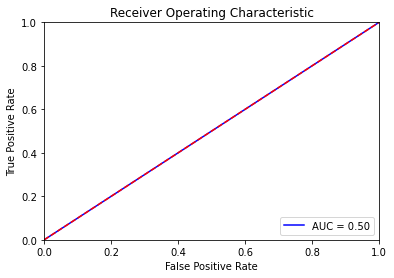

0.5


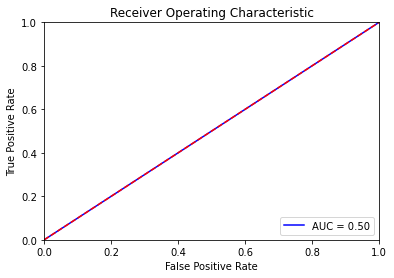

0.5


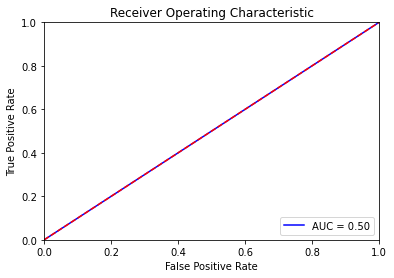

In [29]:
print(compute_auroc(df_test['churned'], df_test['churned']))
print(compute_auroc(df_test['churned'], alwaysChurn )) # Auroc if we always predict churn
plot_auroc(df_test['churned'], alwaysChurn )
print(compute_auroc(df_test['churned'], neverChurn)) # Auroc if we never predict churn
plot_auroc(df_test['churned'], neverChurn)
print(compute_auroc(df_test['churned'], meanChurn)) # Auroc if we predict the mean as probability of churning
plot_auroc(df_test['churned'], meanChurn)

## Decision trees

One way to understand decision trees is by first manually creating a decision tree ourselves.

In [30]:
df_train.groupby("huidig_contractduur")['churned'].mean()

huidig_contractduur
12    0.504228
24    0.686469
36    0.388289
60    0.000000
99    0.000000
Name: churned, dtype: float64

In [31]:
def model1(row):
    if row.huidig_contractduur == 12:
        return 0.504228
    elif row.huidig_contractduur == 24:
        return 0.686469
    elif row.huidig_contractduur == 36:
        return 0.388289
    elif row.huidig_contractduur >=60:
        return 0
    else:
        return 0.410952 # Mean value across the whole dataset.

In [32]:
predictions1 = df_test.apply(model1, axis=1)
predictions1.head()

9098    0.504228
6899    0.504228
6961    0.504228
4411    0.388289
6574    0.504228
dtype: float64

In [33]:
predictions1.value_counts()

0.504228    1664
0.388289     755
0.000000     442
0.686469     121
dtype: int64

In [34]:
compute_rmse(df_test['churned'], predictions1)

0.4567346384199409

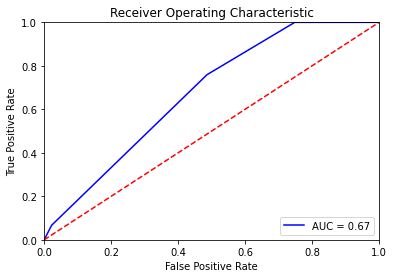

0.6746380157335186

In [35]:
plot_auroc(df_test['churned'], predictions1)
compute_auroc(df_test['churned'], predictions1)

In [36]:
featuresModel1 = ['huidig_contractduur'] # , 'levensfase','bouwjaar'

In [37]:
df_train[featuresModel1].head()

,huidig_contractduur
2198,99
9240,12
787,24
934,24
3309,12


In [38]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(df_train[featuresModel1], df_train['churned'])

DecisionTreeClassifier()

In [39]:
def apply_model(model, features, validation_function = compute_rmse, print_to_screen = True, show_auroc = False):
    pred_tree_train = model.predict_proba(df_train[features])
    pred_tree_test = model.predict_proba(df_test[features])
    
    pred_churn_tree_train = pd.Series(map(lambda x: x[1], pred_tree_train))
    pred_churn_tree_test = pd.Series(map(lambda x: x[1], pred_tree_test))
    
    validation_result_train = validation_function(df_train['churned'], pred_churn_tree_train) 
    validation_result_test = validation_function(df_test['churned'], pred_churn_tree_test)
    
    if(print_to_screen):
        print( "Result on trainset:" )
        print( validation_result_train )
        print()
        print( "Result on testset:" )
        print( validation_result_test )
    if(show_auroc):
        plot_auroc(df_test['churned'], pred_churn_tree_test)
    
    return (validation_result_train, validation_result_test)

In [40]:
apply_model(dt, featuresModel1)

Result on trainset:
0.45790040185942854

Result on testset:
0.45673464194599184


(0.45790040185942854, 0.45673464194599184)

Result on trainset:
0.670982919179644

Result on testset:
0.6746380157335186


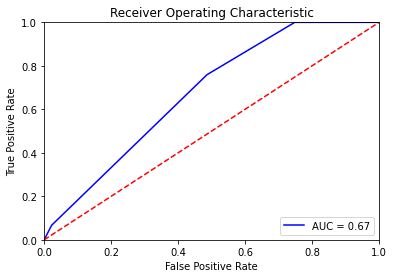

(0.670982919179644, 0.6746380157335186)

In [41]:
apply_model(dt, featuresModel1, validation_function=compute_auroc, show_auroc=True)

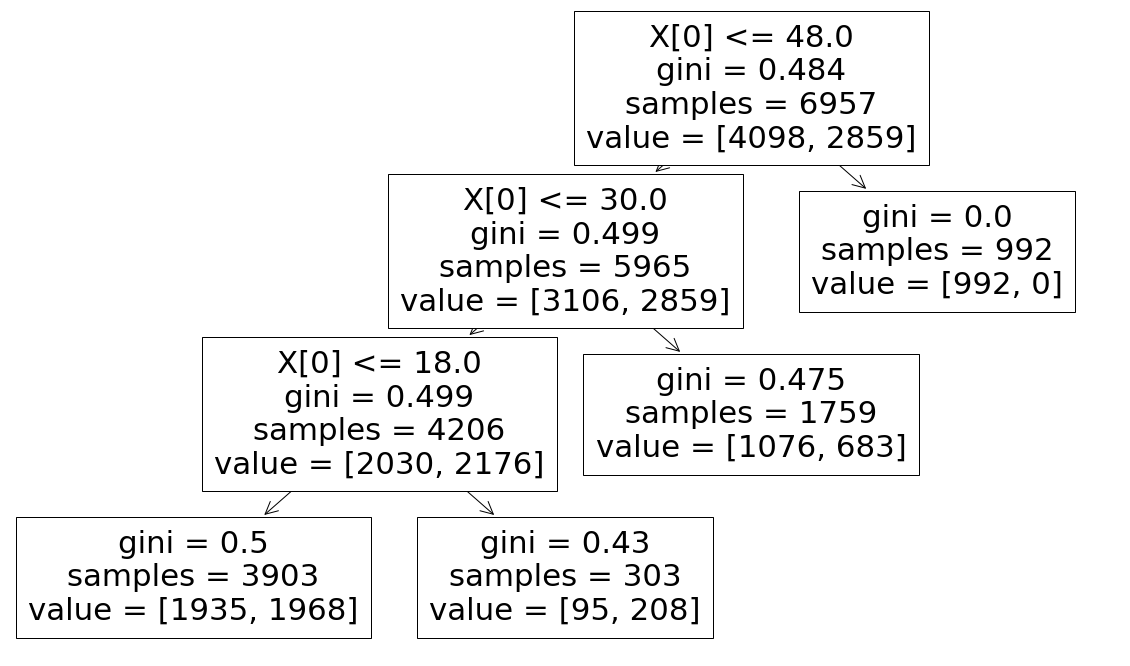

In [42]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(20,12))
plot_tree(dt)
plt.show()

We can also make a much prettier version! If you want to do this you'll need to install Graphviz. It can be installed through Anaconda with `conda install -c anaconda graphviz` in the Anaconda prompt. Be sure though to run the Anaconda prompt as Admin for avoiding privileges permission errors.

The code below plots the tree, but with column names instead of indices. You can also see what the prediction will be at each **leaf** (lowest nodes on the tree).
In this way you can really understand what the model has learned about the data set!

(By the way, it also stores a pdf with the full tree in the same directory as the notebook, called 'decision_tree.pdf'.)

In [43]:
from sklearn import tree
import graphviz

def plot_tree(model, features):
    # Generate plot data
    dot_data = tree.export_graphviz(model, out_file=None, 
                          feature_names=features,  
                          class_names=['not churned', 'churned'],  
                          filled=True, rounded=True,  
                          special_characters=True)  

    # Turn into graph using graphviz
    graph = graphviz.Source(dot_data)  

    # Write out a pdf
    graph.render("decision_tree")

    # Display in the notebook
    return graph 

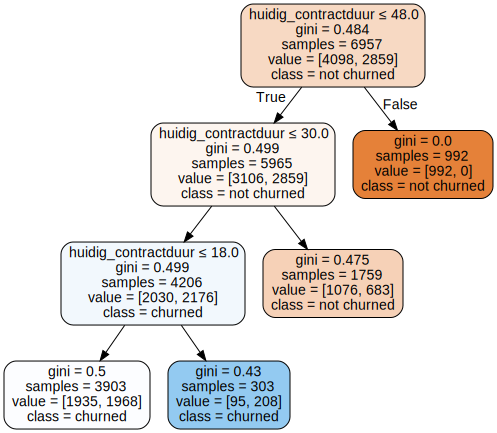

In [44]:
plot_tree(dt, featuresModel1)

## Overfitting

In [45]:
featuresModel2 = ['huidig_contractduur', 'VERBRUIKGAS']
dt2 = DecisionTreeClassifier()
dt2.fit(df_train[featuresModel2], df_train['churned'])

DecisionTreeClassifier()

In [46]:
apply_model(dt2, featuresModel2)

Result on trainset:
0.27478857157993486

Result on testset:
0.5889890060449754


(0.27478857157993486, 0.5889890060449754)

In [47]:
apply_model(dt2, featuresModel2, validation_function=compute_auroc)

Result on trainset:
0.9619908601624658

Result on testset:
0.6037647199812715


(0.9619908601624658, 0.6037647199812715)

In [48]:
# It's best not to plot this tree because it's very big and takes a long time to plot.
# plot_tree(dt2, featuresModel2)

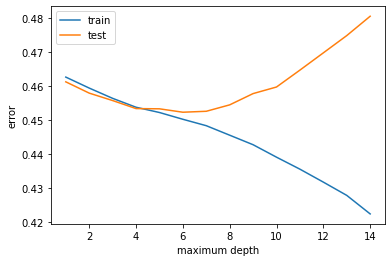

In [49]:
err_train = []
err_test = []
depths = range(1, 15)

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(df_train[featuresModel2], df_train['churned'])
    err_train_i, err_test_i = apply_model(dt, featuresModel2, print_to_screen=False)
    err_train.append(err_train_i)
    err_test.append(err_test_i)
    
plt.plot(depths, err_train, label='train')
plt.plot(depths, err_test, label='test')
plt.legend()
plt.xlabel('maximum depth')
plt.ylabel('error')
plt.show()

In [50]:
dt3 = DecisionTreeClassifier(max_depth=5)
dt3.fit(df_train[featuresModel2], df_train['churned'])

DecisionTreeClassifier(max_depth=5)

In [51]:
apply_model(dt3, featuresModel2)

Result on trainset:
0.4521887075213101

Result on testset:
0.4532721960694224


(0.4521887075213101, 0.4532721960694224)

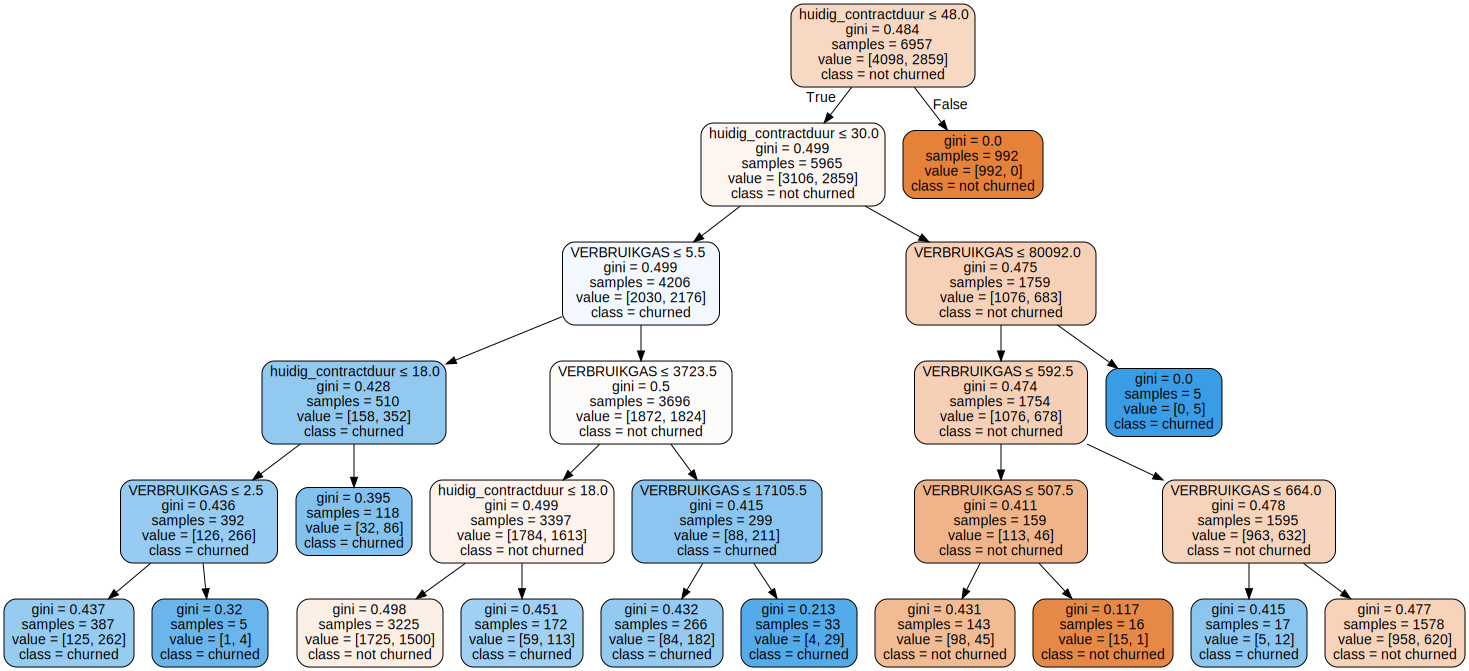

In [52]:
plot_tree(dt3, featuresModel2)

## Decision trees summary

Pro:
- Human readable and easy to understand

Con:
- Prone to overfitting. Prune the tree to mitigate this issue.
- Can not learn as complex hypotheses as more advanced models like Neural Networks and Random Forests

## Random forests

![](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526467744/voting_dnjweq.jpg)

Result on trainset:
0.4181496265522918

Result on testset:
0.41845501372547167


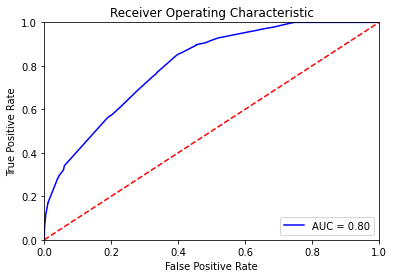

(0.4181496265522918, 0.41845501372547167)

In [53]:
from sklearn.ensemble import RandomForestClassifier

featuresModelRF = ['huidig_contractduur', 'Door 2 Door', 'Inbound', 'Online', 'Prijsvergelijker',
       'Speciale sales acties', 'Telemarketing', 'vaste_prijs', 'groene_stroom'] 
forest = RandomForestClassifier(n_estimators=200)
forest.fit(df_train[featuresModelRF], df_train['churned'])

apply_model(forest, featuresModelRF, show_auroc=True)

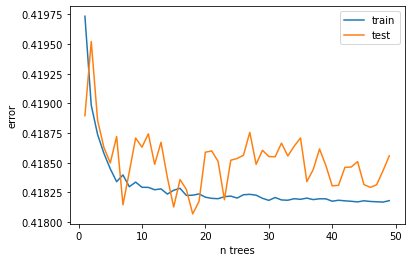

In [54]:
err_train = []
err_test = []
n_trees = range(1, 50)

for n_tree in n_trees:
    rf = RandomForestClassifier(n_estimators=n_tree)
    rf.fit(df_train[featuresModelRF], df_train['churned'])
    err_train_i, err_test_i = apply_model(rf, featuresModelRF, print_to_screen=False)
    err_train.append(err_train_i)
    err_test.append(err_test_i)
    
plt.plot(n_trees, err_train, label='train')
plt.plot(n_trees, err_test, label='test')
plt.legend()
plt.xlabel('n trees')
plt.ylabel('error')
plt.show()

In [55]:
forest.feature_importances_

array([0.65678976, 0.02374198, 0.00775129, 0.01387689, 0.02556371,
       0.03196356, 0.01942734, 0.12271403, 0.09817144])

Feature ranking:
1. feature 0 huidig_contractduur (0.656790)
2. feature 7 Door 2 Door (0.122714)
3. feature 8 Inbound (0.098171)
4. feature 5 Online (0.031964)
5. feature 4 Prijsvergelijker (0.025564)
6. feature 1 Speciale sales acties (0.023742)
7. feature 6 Telemarketing (0.019427)
8. feature 3 vaste_prijs (0.013877)
9. feature 2 groene_stroom (0.007751)


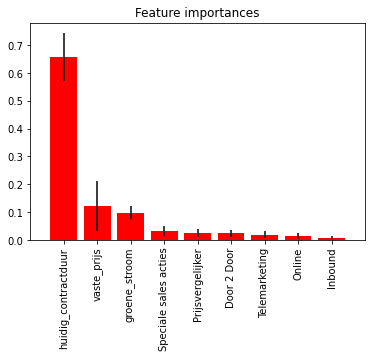

In [56]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = pd.Series(featuresModelRF)

# Print the feature ranking
print("Feature ranking:")

for f in range(len(featuresModelRF)):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], features[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(featuresModelRF)), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(len(featuresModelRF)), features[indices], rotation = 90)
plt.xlim([-1, len(featuresModelRF)])
plt.show()

## Random forest summary:

Pro:
- Can learn complex hypotheses compared to models like decision trees, linear and logistic regression
- Can rank features based on important. Can be used for feature selection.
- Does not need a test set to be evaluated. Can use [Out Of Bag error](https://stackoverflow.com/questions/18541923/what-is-out-of-bag-error-in-random-forests) instead. 
- The training algorithm scales very well with the number of rows and number of features. Time complexity for building a random forest is `O(#rows*log(#rows)*#features*#trees)`.

Con:
- Loses the readability and interpretability that decision trees have.